# Method 7 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

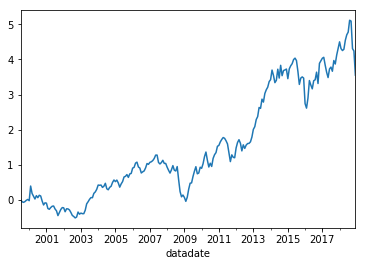

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.013391
2000-12-31   -0.095043
2001-12-31   -0.147431
2002-12-31   -0.240406
2003-12-31    1.192385
2004-12-31    0.203758
2005-12-31    0.119732
2006-12-31    0.147177
2007-12-31    0.012390
2008-12-31   -0.441055
2009-12-31    0.695438
2010-12-31    0.307722
2011-12-31   -0.128832
2012-12-31    0.268136
2013-12-31    0.565189
2014-12-31    0.081961
2015-12-31   -0.054448
2016-12-31    0.110624
2017-12-31    0.070056
2018-12-31   -0.142900
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     259.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.48e-84
Time:                        22:17:02   Log-Likelihood:                 466.01
No. Observations:                 234   AIC:                            -922.0
Df Residuals:                     229   BIC:                            -904.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      1.958      0.051   -2.81e-05       0.009
mktrf          0.9464      0.062     15.199      0.000       0.824       1.069
me             0.8770      0.072     12.108      0.000       0.734       1.020
ia             0.1176      0.110      1.068      0.287      -0.099       0.334
roe           -0.6762      0.094     -7.177      0.000      -0.862      -0.491
==============================================================================
Omnibus:                       40.266   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.898
Skew:                           0.375   Prob(JB):                     3.34e-60
Kurtosis:                       8.247   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     256.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-83
Time:                        22:17:02   Log-Likelihood:                 466.01
No. Observations:                 234   AIC:                            -922.0
Df Residuals:                     229   BIC:                            -904.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.609      0.108      -0.001       0.010
mktrf          0.9464      0.065     14.460      0.000       0.818       1.075
me             0.8770      0.134      6.537      0.000       0.614       1.140
ia             0.1176      0.176      0.669      0.504      -0.227       0.462
roe           -0.6762      0.203     -3.328      0.001      -1.075      -0.278
==============================================================================
Omnibus:                       40.266   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.898
Skew:                           0.375   Prob(JB):                     3.34e-60
Kurtosis:                       8.247   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     333.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.98e-94
Time:                        22:17:02   Log-Likelihood:                 466.01
No. Observations:                 234   AIC:                            -922.0
Df Residuals:                     229   BIC:                            -904.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.463      0.143      -0.002       0.010
mktrf          0.9464      0.057     16.594      0.000       0.835       1.058
me             0.8770      0.135      6.511      0.000       0.613       1.141
ia             0.1176      0.153      0.767      0.443      -0.183       0.418
roe           -0.6762      0.232     -2.919      0.004      -1.130      -0.222
==============================================================================
Omnibus:                       40.266   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.898
Skew:                           0.375   Prob(JB):                     3.34e-60
Kurtosis:                       8.247   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     216.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.60e-84
Time:                        22:17:03   Log-Likelihood:                 470.76
No. Observations:                 234   AIC:                            -929.5
Df Residuals:                     228   BIC:                            -908.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.067      0.040       0.000       0.009
mktrf          1.0040      0.061     16.386      0.000       0.883       1.125
smb            0.8046      0.081      9.953      0.000       0.645       0.964
hml            0.0347      0.095      0.364      0.716      -0.153       0.223
rmw           -0.7789      0.108     -7.227      0.000      -0.991      -0.567
cma            0.3576      0.137      2.610      0.010       0.088       0.628
==============================================================================
Omnibus:                       22.814   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.833
Skew:                           0.042   Prob(JB):                     5.70e-22
Kurtosis:                       6.167   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     202.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.22e-82
Time:                        22:17:03   Log-Likelihood:                 470.76
No. Observations:                 234   AIC:                            -929.5
Df Residuals:                     228   BIC:                            -908.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.094      0.036       0.000       0.009
mktrf          1.0040      0.065     15.411      0.000       0.876       1.132
smb            0.8046      0.066     12.188      0.000       0.675       0.934
hml            0.0347      0.150      0.231      0.817      -0.260       0.329
rmw           -0.7789      0.151     -5.142      0.000      -1.076      -0.482
cma            0.3576      0.210      1.702      0.089      -0.054       0.769
==============================================================================
Omnibus:                       22.814   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.833
Skew:                           0.042   Prob(JB):                     5.70e-22
Kurtosis:                       6.167   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     250.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.72e-90
Time:                        22:17:03   Log-Likelihood:                 470.76
No. Observations:                 234   AIC:                            -929.5
Df Residuals:                     228   BIC:                            -908.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.002      2.032      0.042       0.000       0.009
mktrf          1.0040      0.066     15.262      0.000       0.875       1.133
smb            0.8046      0.055     14.669      0.000       0.697       0.912
hml            0.0347      0.142      0.245      0.807      -0.243       0.313
rmw           -0.7789      0.165     -4.730      0.000      -1.102      -0.456
cma            0.3576      0.174      2.051      0.040       0.016       0.699
==============================================================================
Omnibus:                       22.814   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.833
Skew:                           0.042   Prob(JB):                     5.70e-22
Kurtosis:                       6.167   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     220.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.69e-77
Time:                        22:17:03   Log-Likelihood:                 450.79
No. Observations:                 234   AIC:                            -891.6
Df Residuals:                     229   BIC:                            -874.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.023      0.308      -0.002       0.007
mktrf          1.0827      0.061     17.697      0.000       0.962       1.203
smb            1.1248      0.076     14.728      0.000       0.974       1.275
hml            0.0917      0.076      1.208      0.228      -0.058       0.241
umd           -0.1694      0.050     -3.403      0.001      -0.267      -0.071
==============================================================================
Omnibus:                       48.742   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.883
Skew:                           0.520   Prob(JB):                     7.91e-81
Kurtosis:                       9.062   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     230.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.41e-79
Time:                        22:17:03   Log-Likelihood:                 450.79
No. Observations:                 234   AIC:                            -891.6
Df Residuals:                     229   BIC:                            -874.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.032      0.302      -0.002       0.007
mktrf          1.0827      0.065     16.727      0.000       0.956       1.210
smb            1.1248      0.141      8.004      0.000       0.849       1.400
hml            0.0917      0.113      0.811      0.417      -0.130       0.313
umd           -0.1694      0.105     -1.613      0.107      -0.375       0.036
==============================================================================
Omnibus:                       48.742   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.883
Skew:                           0.520   Prob(JB):                     7.91e-81
Kurtosis:                       9.062   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     226.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.17e-78
Time:                        22:17:03   Log-Likelihood:                 450.79
No. Observations:                 234   AIC:                            -891.6
Df Residuals:                     229   BIC:                            -874.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      0.984      0.325      -0.002       0.007
mktrf          1.0827      0.056     19.278      0.000       0.973       1.193
smb            1.1248      0.112     10.079      0.000       0.906       1.344
hml            0.0917      0.117      0.784      0.433      -0.137       0.321
umd           -0.1694      0.103     -1.647      0.100      -0.371       0.032
==============================================================================
Omnibus:                       48.742   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.883
Skew:                           0.520   Prob(JB):                     7.91e-81
Kurtosis:                       9.062   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     114.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.59e-39
Time:                        22:17:03   Log-Likelihood:                 212.27
No. Observations:                 120   AIC:                            -414.5
Df Residuals:                     115   BIC:                            -400.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.004      1.340      0.183      -0.003       0.013
mktrf          0.9874      0.109      9.089      0.000       0.772       1.203
me             0.9269      0.107      8.639      0.000       0.714       1.139
ia             0.1305      0.168      0.777      0.439      -0.202       0.463
roe           -0.5972      0.149     -4.016      0.000      -0.892      -0.303
==============================================================================
Omnibus:                       15.757   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.448
Skew:                           0.306   Prob(JB):                     3.02e-11
Kurtosis:                       6.052   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     119.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.31e-40
Time:                        22:17:03   Log-Likelihood:                 212.27
No. Observations:                 120   AIC:                            -414.5
Df Residuals:                     115   BIC:                            -400.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.005      1.062      0.288      -0.005       0.015
mktrf          0.9874      0.107      9.241      0.000       0.778       1.197
me             0.9269      0.180      5.145      0.000       0.574       1.280
ia             0.1305      0.244      0.534      0.593      -0.348       0.609
roe           -0.5972      0.285     -2.095      0.036      -1.156      -0.039
==============================================================================
Omnibus:                       15.757   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.448
Skew:                           0.306   Prob(JB):                     3.02e-11
Kurtosis:                       6.052   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     174.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.41e-48
Time:                        22:17:03   Log-Likelihood:                 212.27
No. Observations:                 120   AIC:                            -414.5
Df Residuals:                     115   BIC:                            -400.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.006      0.947      0.344      -0.006       0.017
mktrf          0.9874      0.095     10.424      0.000       0.802       1.173
me             0.9269      0.187      4.967      0.000       0.561       1.293
ia             0.1305      0.221      0.590      0.555      -0.303       0.564
roe           -0.5972      0.327     -1.827      0.068      -1.238       0.043
==============================================================================
Omnibus:                       15.757   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.448
Skew:                           0.306   Prob(JB):                     3.02e-11
Kurtosis:                       6.052   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     103.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-40
Time:                        22:17:03   Log-Likelihood:                 218.62
No. Observations:                 120   AIC:                            -425.2
Df Residuals:                     114   BIC:                            -408.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      2.018      0.046       0.000       0.016
mktrf          1.0457      0.109      9.582      0.000       0.829       1.262
smb            0.8112      0.124      6.564      0.000       0.566       1.056
hml           -0.0010      0.151     -0.007      0.995      -0.301       0.299
rmw           -0.7741      0.179     -4.335      0.000      -1.128      -0.420
cma            0.4720      0.196      2.413      0.017       0.084       0.860
==============================================================================
Omnibus:                        9.389   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               18.995
Skew:                          -0.194   Prob(JB):                     7.50e-05
Kurtosis:                       4.910   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     148.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.89e-48
Time:                        22:17:03   Log-Likelihood:                 218.62
No. Observations:                 120   AIC:                            -425.2
Df Residuals:                     114   BIC:                            -408.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      2.038      0.042       0.000       0.016
mktrf          1.0457      0.127      8.241      0.000       0.797       1.294
smb            0.8112      0.098      8.314      0.000       0.620       1.002
hml           -0.0010      0.259     -0.004      0.997      -0.508       0.506
rmw           -0.7741      0.257     -3.012      0.003      -1.278      -0.270
cma            0.4720      0.255      1.852      0.064      -0.028       0.972
==============================================================================
Omnibus:                        9.389   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               18.995
Skew:                          -0.194   Prob(JB):                     7.50e-05
Kurtosis:                       4.910   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     268.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.44e-61
Time:                        22:17:03   Log-Likelihood:                 218.62
No. Observations:                 120   AIC:                            -425.2
Df Residuals:                     114   BIC:                            -408.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      1.989      0.047       0.000       0.016
mktrf          1.0457      0.128      8.188      0.000       0.795       1.296
smb            0.8112      0.088      9.183      0.000       0.638       0.984
hml           -0.0010      0.259     -0.004      0.997      -0.508       0.506
rmw           -0.7741      0.281     -2.753      0.006      -1.325      -0.223
cma            0.4720      0.195      2.423      0.015       0.090       0.854
==============================================================================
Omnibus:                        9.389   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               18.995
Skew:                          -0.194   Prob(JB):                     7.50e-05
Kurtosis:                       4.910   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     107.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.10e-38
Time:                        22:17:03   Log-Likelihood:                 209.00
No. Observations:                 120   AIC:                            -408.0
Df Residuals:                     115   BIC:                            -394.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.216      0.227      -0.003       0.013
mktrf          1.1215      0.098     11.403      0.000       0.927       1.316
smb            1.1762      0.112     10.504      0.000       0.954       1.398
hml            0.0779      0.112      0.695      0.489      -0.144       0.300
umd           -0.1687      0.069     -2.440      0.016      -0.306      -0.032
==============================================================================
Omnibus:                       18.815   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.218
Skew:                           0.193   Prob(JB):                     1.90e-19
Kurtosis:                       7.135   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     112.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.02e-39
Time:                        22:17:03   Log-Likelihood:                 209.00
No. Observations:                 120   AIC:                            -408.0
Df Residuals:                     115   BIC:                            -394.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.280      0.200      -0.003       0.012
mktrf          1.1215      0.100     11.196      0.000       0.925       1.318
smb            1.1762      0.177      6.644      0.000       0.829       1.523
hml            0.0779      0.163      0.477      0.634      -0.243       0.398
umd           -0.1687      0.129     -1.304      0.192      -0.422       0.085
==============================================================================
Omnibus:                       18.815   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.218
Skew:                           0.193   Prob(JB):                     1.90e-19
Kurtosis:                       7.135   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     131.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.91e-42
Time:                        22:17:03   Log-Likelihood:                 209.00
No. Observations:                 120   AIC:                            -408.0
Df Residuals:                     115   BIC:                            -394.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.179      0.238      -0.003       0.013
mktrf          1.1215      0.085     13.202      0.000       0.955       1.288
smb            1.1762      0.145      8.102      0.000       0.892       1.461
hml            0.0779      0.185      0.421      0.674      -0.285       0.440
umd           -0.1687      0.119     -1.420      0.156      -0.402       0.064
==============================================================================
Omnibus:                       18.815   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.218
Skew:                           0.193   Prob(JB):                     1.90e-19
Kurtosis:                       7.135   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.15e-49
Time:                        22:17:03   Log-Likelihood:                 282.62
No. Observations:                 114   AIC:                            -555.2
Df Residuals:                     109   BIC:                            -541.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.503      0.136      -0.001       0.007
mktrf          0.9645      0.061     15.817      0.000       0.844       1.085
me             0.6990      0.094      7.425      0.000       0.512       0.886
ia             0.0234      0.131      0.179      0.858      -0.235       0.282
roe           -0.8906      0.115     -7.761      0.000      -1.118      -0.663
==============================================================================
Omnibus:                        0.217   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.122
Skew:                           0.080   Prob(JB):                        0.941
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     424.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-65
Time:                        22:17:03   Log-Likelihood:                 282.62
No. Observations:                 114   AIC:                            -555.2
Df Residuals:                     109   BIC:                            -541.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.193      0.028       0.000       0.006
mktrf          0.9645      0.047     20.313      0.000       0.871       1.058
me             0.6990      0.058     11.974      0.000       0.585       0.813
ia             0.0234      0.169      0.139      0.890      -0.308       0.354
roe           -0.8906      0.149     -5.976      0.000      -1.183      -0.598
==============================================================================
Omnibus:                        0.217   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.122
Skew:                           0.080   Prob(JB):                        0.941
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     541.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.55e-71
Time:                        22:17:03   Log-Likelihood:                 282.62
No. Observations:                 114   AIC:                            -555.2
Df Residuals:                     109   BIC:                            -541.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      2.048      0.041       0.000       0.006
mktrf          0.9645      0.048     20.120      0.000       0.871       1.058
me             0.6990      0.049     14.198      0.000       0.602       0.795
ia             0.0234      0.187      0.125      0.901      -0.343       0.390
roe           -0.8906      0.124     -7.154      0.000      -1.135      -0.647
==============================================================================
Omnibus:                        0.217   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.122
Skew:                           0.080   Prob(JB):                        0.941
Kurtosis:                       2.992   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     132.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.31e-44
Time:                        22:17:03   Log-Likelihood:                 273.63
No. Observations:                 114   AIC:                            -535.3
Df Residuals:                     108   BIC:                            -518.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.479      0.633      -0.003       0.006
mktrf          1.0223      0.063     16.170      0.000       0.897       1.148
smb            0.7170      0.103      6.986      0.000       0.514       0.920
hml            0.1723      0.131      1.316      0.191      -0.087       0.432
rmw           -0.7536      0.160     -4.702      0.000      -1.071      -0.436
cma           -0.0338      0.203     -0.166      0.868      -0.437       0.369
==============================================================================
Omnibus:                        6.870   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               12.222
Skew:                           0.041   Prob(JB):                      0.00222
Kurtosis:                       4.602   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     134.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-44
Time:                        22:17:03   Log-Likelihood:                 273.63
No. Observations:                 114   AIC:                            -535.3
Df Residuals:                     108   BIC:                            -518.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.636      0.525      -0.002       0.004
mktrf          1.0223      0.059     17.404      0.000       0.907       1.137
smb            0.7170      0.079      9.093      0.000       0.562       0.872
hml            0.1723      0.090      1.914      0.056      -0.004       0.349
rmw           -0.7536      0.213     -3.537      0.000      -1.171      -0.336
cma           -0.0338      0.215     -0.158      0.875      -0.455       0.387
==============================================================================
Omnibus:                        6.870   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               12.222
Skew:                           0.041   Prob(JB):                      0.00222
Kurtosis:                       4.602   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     163.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-48
Time:                        22:17:03   Log-Likelihood:                 273.63
No. Observations:                 114   AIC:                            -535.3
Df Residuals:                     108   BIC:                            -518.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.577      0.564      -0.003       0.005
mktrf          1.0223      0.065     15.643      0.000       0.894       1.150
smb            0.7170      0.082      8.758      0.000       0.557       0.877
hml            0.1723      0.103      1.667      0.096      -0.030       0.375
rmw           -0.7536      0.227     -3.314      0.001      -1.199      -0.308
cma           -0.0338      0.255     -0.133      0.895      -0.534       0.466
==============================================================================
Omnibus:                        6.870   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               12.222
Skew:                           0.041   Prob(JB):                      0.00222
Kurtosis:                       4.602   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     131.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.75e-41
Time:                        22:17:03   Log-Likelihood:                 262.35
No. Observations:                 114   AIC:                            -514.7
Df Residuals:                     109   BIC:                            -501.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.044      0.965      -0.005       0.005
mktrf          1.0690      0.069     15.485      0.000       0.932       1.206
smb            0.8732      0.108      8.113      0.000       0.660       1.087
hml            0.2575      0.111      2.323      0.022       0.038       0.477
umd           -0.1231      0.084     -1.472      0.144      -0.289       0.043
==============================================================================
Omnibus:                        9.881   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               21.765
Skew:                           0.175   Prob(JB):                     1.88e-05
Kurtosis:                       5.112   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     166.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-45
Time:                        22:17:03   Log-Likelihood:                 262.35
No. Observations:                 114   AIC:                            -514.7
Df Residuals:                     109   BIC:                            -501.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.056      0.956      -0.004       0.004
mktrf          1.0690      0.056     19.167      0.000       0.960       1.178
smb            0.8732      0.084     10.384      0.000       0.708       1.038
hml            0.2575      0.122      2.117      0.034       0.019       0.496
umd           -0.1231      0.076     -1.622      0.105      -0.272       0.026
==============================================================================
Omnibus:                        9.881   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               21.765
Skew:                           0.175   Prob(JB):                     1.88e-05
Kurtosis:                       5.112   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     192.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-48
Time:                        22:17:03   Log-Likelihood:                 262.35
No. Observations:                 114   AIC:                            -514.7
Df Residuals:                     109   BIC:                            -501.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.053      0.958      -0.004       0.004
mktrf          1.0690      0.058     18.449      0.000       0.955       1.183
smb            0.8732      0.068     12.880      0.000       0.740       1.006
hml            0.2575      0.115      2.241      0.025       0.032       0.483
umd           -0.1231      0.062     -1.973      0.049      -0.245      -0.001
==============================================================================
Omnibus:                        9.881   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               21.765
Skew:                           0.175   Prob(JB):                     1.88e-05
Kurtosis:                       5.112   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""